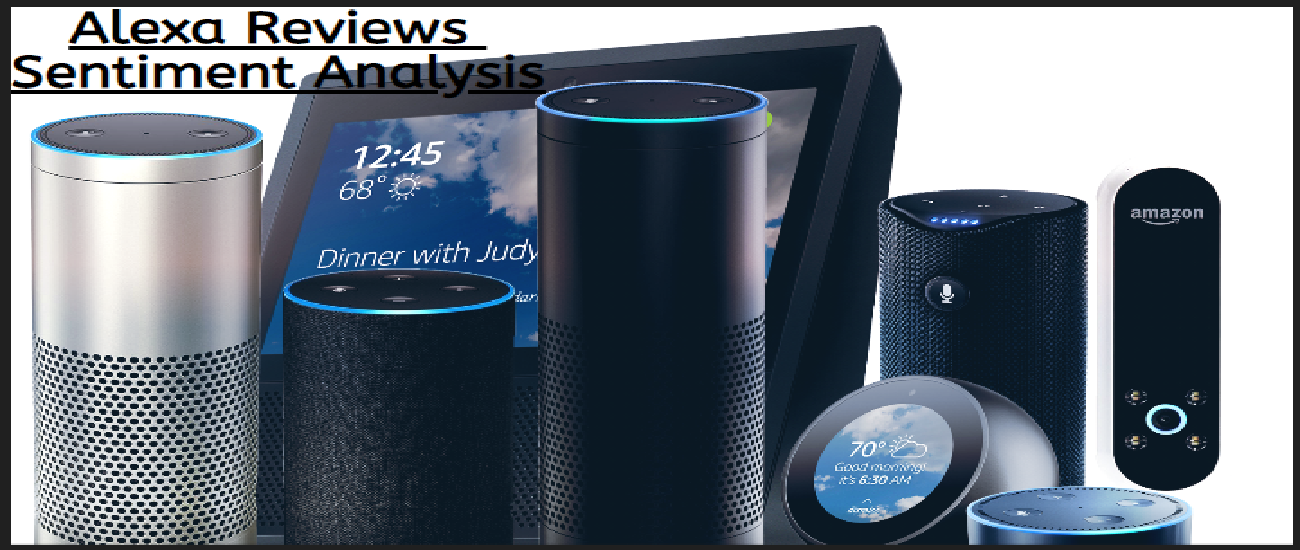

### Import required library

In [30]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px # plots

import nltk
import re
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#MODEL BUILDING
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

from nltk.sentiment.vader import SentimentIntensityAnalyzer

### Read the dataset

In [2]:
df=pd.read_csv('D:\PGP IN DATA SCIENCE with Careerera\Data Sets\\NLP Dataset\\amazon.alexa.csv')
df.head()

rating       date         variation  \
0       5  31-Jul-18  Charcoal Fabric    
1       5  31-Jul-18  Charcoal Fabric    
2       4  31-Jul-18    Walnut Finish    
3       5  31-Jul-18  Charcoal Fabric    
4       5  31-Jul-18  Charcoal Fabric    

                                    verified_reviews  feedback  
0                                      Love my Echo!         1  
1                                          Loved it!         1  
2  Sometimes while playing a game, you can answer...         1  
3  I have had a lot of fun with this thing. My 4 ...         1  
4                                              Music         1

### Exploring the dataset

In [3]:
df.size

15750

In [4]:
df.shape

(3150, 5)

In [5]:
df.columns

Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback'], dtype='object')

In [6]:
df.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
dtype: object

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3150 non-null   int64 
 1   date              3150 non-null   object
 2   variation         3150 non-null   object
 3   verified_reviews  3150 non-null   object
 4   feedback          3150 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 123.2+ KB


In [8]:
df.isna().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [9]:
df.describe()

rating     feedback
count  3150.000000  3150.000000
mean      4.463175     0.918413
std       1.068506     0.273778
min       1.000000     0.000000
25%       4.000000     1.000000
50%       5.000000     1.000000
75%       5.000000     1.000000
max       5.000000     1.000000

1. **5 star rating scale**
2. **two types of feedback, 1- positive, 2-Negative.**

In [10]:
df['date']=pd.to_datetime(df['date'])
df.date.min(),df.date.max()

(Timestamp('2018-05-16 00:00:00'), Timestamp('2018-07-31 00:00:00'))

**Feedbacks are available from 16 May 2018 to 31 July 2018.**

### Count of Ratings

In [11]:
ratings=pd.DataFrame(df.rating.value_counts())
ratings.reset_index(inplace=True)
ratings.columns=['rating','count']
ratings

rating  count
0       5   2286
1       4    455
2       1    161
3       3    152
4       2     96

In [12]:
fig=px.pie(ratings, names='rating',
          values='count', hole=0.5,
          labels='rating',
          title='Count of Ratings')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

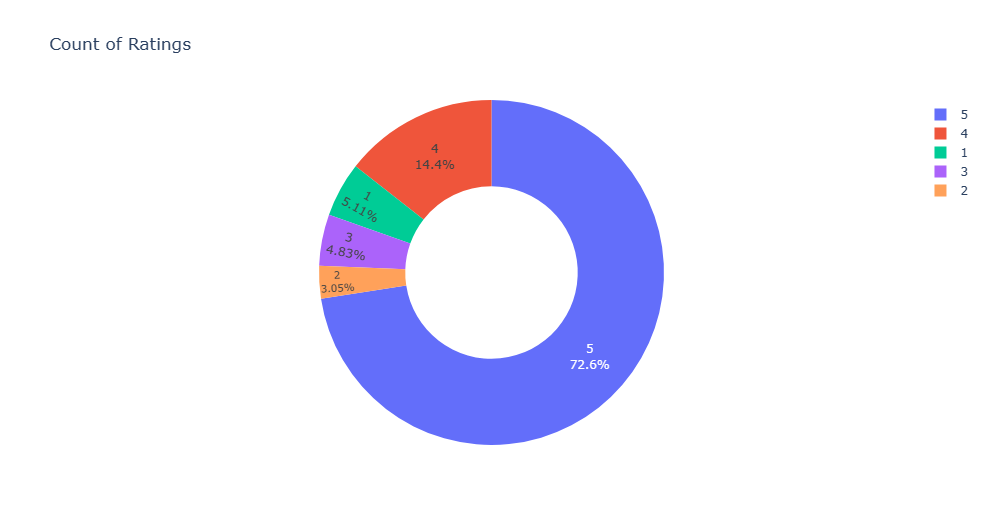

**72.6% ratings are 5 star, 14.4% are 4 star, 4.83% are 3 star, 3.05% are 2 star & 5.11% are 1 Star Rating.**

### Feedback count

In [13]:
feedbacks=pd.DataFrame(df.feedback.value_counts())
feedbacks.reset_index(inplace=True)
feedbacks.columns=['feedback','count']
print(feedbacks)
fig=px.pie(feedbacks, names='feedback',
          values='count', hole=0.5,
          labels='feedback',
          title='Count of Feedback')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

   feedback  count
0         1   2893
1         0    257


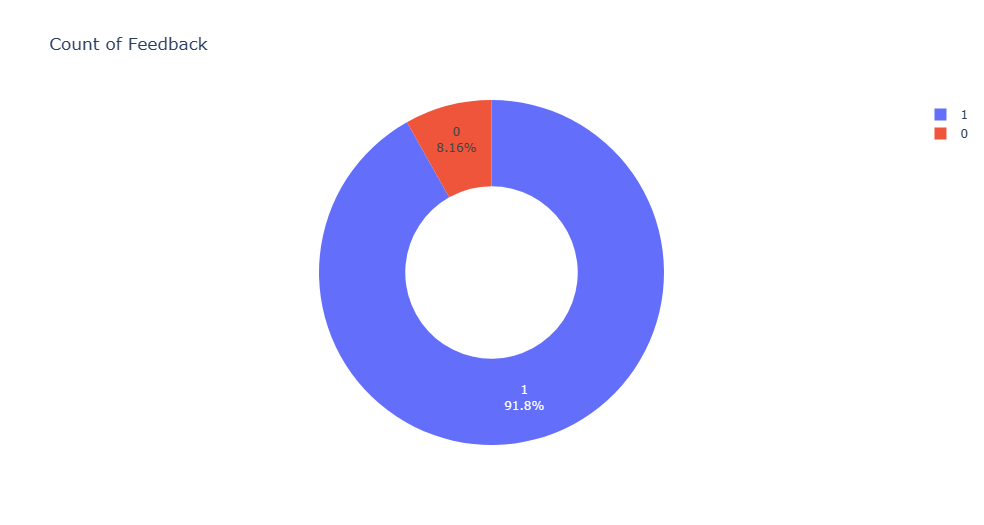

**91.8% feedbacks are Positive ie 1 & only 8.16% feedbacks are negative ie.0.**

### Variety of Product

In [14]:
df.variation.value_counts()

Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
White                            91
Sandstone Fabric                 90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: variation, dtype: int64

### Text Preprocessing

In [15]:
pd.options.display.max_colwidth=100000000

In [16]:
data=df[['verified_reviews','rating']]
data.columns=['review','rating']
data.head()

review  \
0                                                                                                                                                                                        Love my Echo!   
1                                                                                                                                                                                            Loved it!   
2  Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home.   
3                         I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well.   
4                                                                                                                                                                                                Music   

   rating  
0       5  
1       5  
2       4  
3       5  
4       5

##### Reviews contains punctuation, digits, characters, links, emojis etc.. for text analysis we must get rid of these.

#### Function that cleans the Text

In [63]:
stemmer = nltk.SnowballStemmer("english")
lemma= WordNetLemmatizer()
stopwords=set(stopwords.words('english'))

In [64]:
def clean(text):
    text=str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopwords]
    text=" ".join(text)
    text = [lemma.lemmatize(word) for word in text.split(' ')]
    text=" ".join(text)
    return text

In [19]:
data['review']=data['review'].apply(clean)
data.head()

review  \
0                                                                                                    love echo   
1                                                                                                        loved   
2  sometimes playing game answer question correctly alexa say got wrong answer  like able turn light away home   
3    lot fun thing  yr old learns dinosaur control light play game like category nice sound playing music well   
4                                                                                                        music   

   rating  
0       5  
1       5  
2       4  
3       5  
4       5

### Create column sentiment class from ratings

In [20]:
def sentiments(rating):
    if rating>=5:
        return 'positive'
    elif rating>=2 and rating<=4:
        return 'neutral'
    else:
        return 'negative'

data1=data
data1['sentiment_class']=data1['rating'].apply(sentiments)
data1.head()

review  \
0                                                                                                    love echo   
1                                                                                                        loved   
2  sometimes playing game answer question correctly alexa say got wrong answer  like able turn light away home   
3    lot fun thing  yr old learns dinosaur control light play game like category nice sound playing music well   
4                                                                                                        music   

   rating sentiment_class  
0       5        positive  
1       5        positive  
2       4         neutral  
3       5        positive  
4       5        positive

### Plot the most frequently used words in review

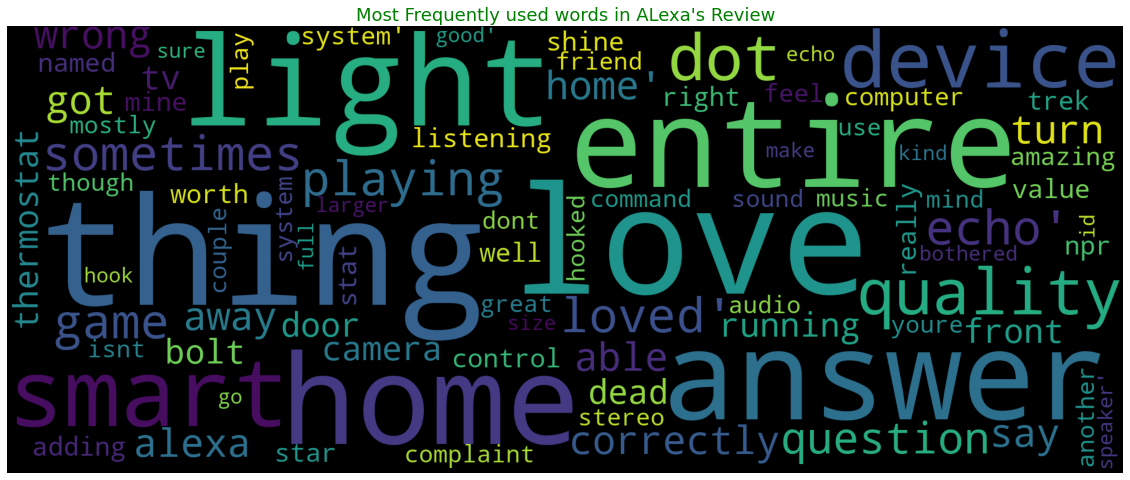

In [21]:
reviews=data1['review'].values
word_cloud=WordCloud(max_words=5000, width=2000, height=800).generate_from_text(str(reviews))
plt.figure(figsize=(20,12))
plt.imshow(word_cloud)
plt.title("Most Frequently used words in ALexa's Review", fontsize=18, color='green')
plt.axis('off');

### Positive Sentiment words

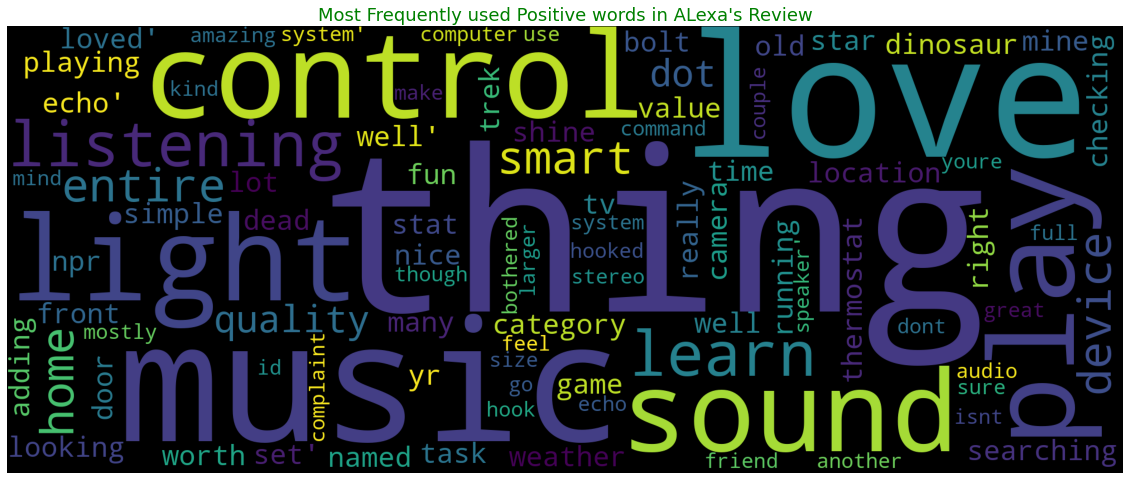

In [22]:
pos=data1[data1['sentiment_class']=='positive']
reviews=pos['review'].values
word_cloud=WordCloud(max_words=5000, width=2000, height=800).generate_from_text(str(reviews))
plt.figure(figsize=(20,12))
plt.imshow(word_cloud)
plt.title("Most Frequently used Positive words in ALexa's Review", fontsize=18, color='green')
plt.axis('off');

### Neutral Sentiment words

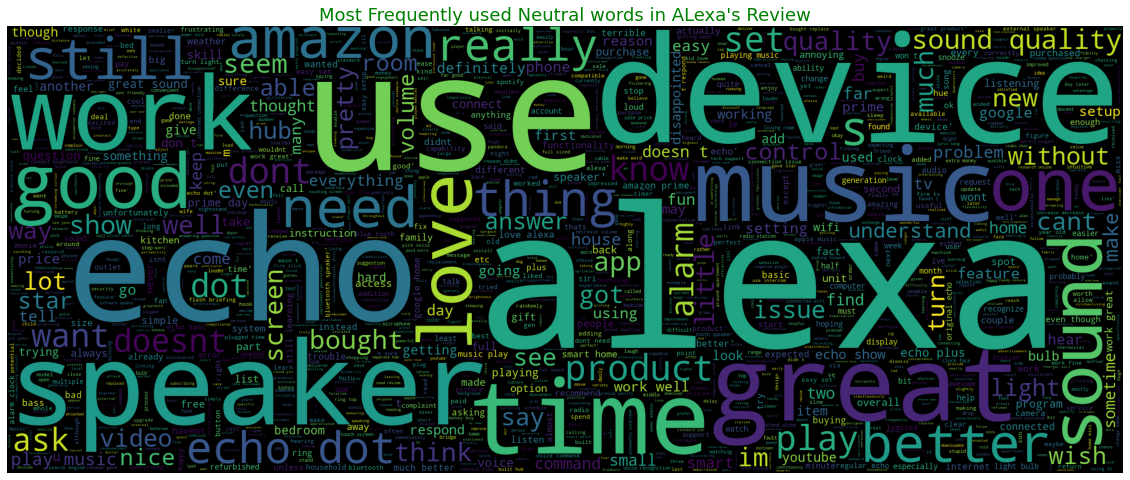

In [23]:
neu=data1[data1['sentiment_class']=='neutral']
reviews=neu['review'].values
word_cloud=WordCloud(max_words=5000, width=2000, height=800).generate_from_text(str(reviews))
plt.figure(figsize=(20,12))
plt.imshow(word_cloud)
plt.title("Most Frequently used Neutral words in ALexa's Review", fontsize=18, color='green')
plt.axis('off');

### Negative Sentiments word

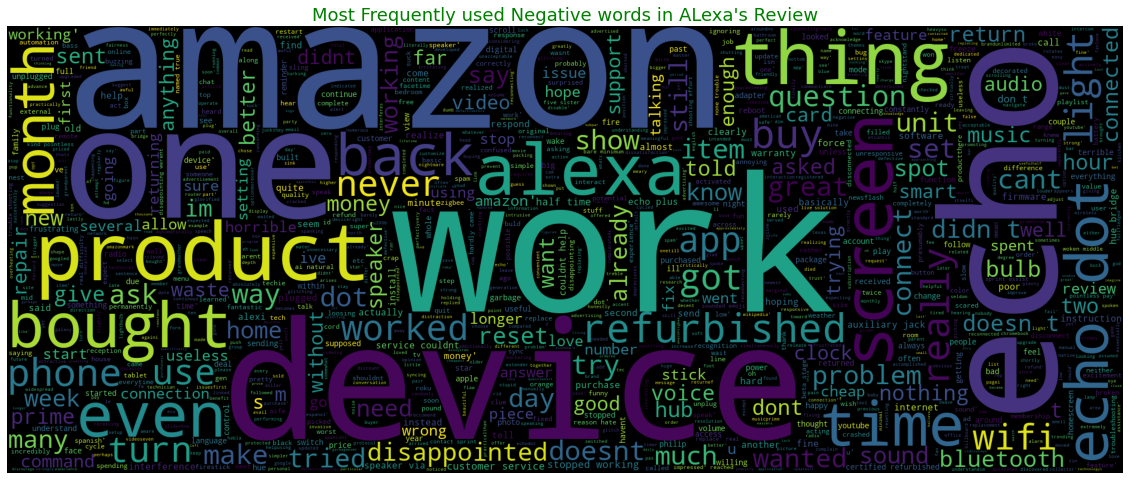

In [24]:
neg=data1[data1['sentiment_class']=='negative']
reviews=neg['review'].values
word_cloud=WordCloud(max_words=5000, width=2000, height=800).generate_from_text(str(reviews))
plt.figure(figsize=(20,12))
plt.imshow(word_cloud)
plt.title("Most Frequently used Negative words in ALexa's Review", fontsize=18, color='green')
plt.axis('off');

### ML Classification model

In [25]:
data1['sentiment_class'].replace({'positive':2,'neutral':1,'negative':0},inplace=True)
data1.sentiment_class.value_counts()

2    2286
1     703
0     161
Name: sentiment_class, dtype: int64

#### Each class contains different number of rows, use undersampling to reduce the number of rows of higher class

In [26]:
neu=data1[data1['sentiment_class']==0]
pos=data1[data1['sentiment_class']==1][:161]
neg=data1[data1['sentiment_class']==2][:161]
data2=pd.concat([neu,pos,neg])
data2.sentiment_class.value_counts()

0    161
1    161
2    161
Name: sentiment_class, dtype: int64

#### Now each sentiment class have same number of rows.

### Create dependent and indepenedet features

In [27]:
x=data2['review']
y=data2['sentiment_class']

### Train test split

In [28]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=0)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(386,) (97,) (386,) (97,)


### To train classification model we need integer as a input, convert text to integer using TfIdf vectorizer

In [31]:
tf=TfidfVectorizer(ngram_range=(1,3))
tf_fitted=tf.fit(x_train)
x_train_tf=tf_fitted.transform(x_train)
x_test_tf=tf_fitted.transform(x_test)

In [32]:
x_train_tf.shape

(386, 10564)

In [33]:
x_test_tf.shape

(97, 10564)

### 1. Logistic Regression

In [34]:
lr=LogisticRegression()
lr.fit(x_train_tf,y_train)
y_pred=lr.predict(x_test_tf)

In [35]:
print(confusion_matrix(y_test,y_pred))
print("Number of mislabeled points out of a total %d points : %d" % (x_test_tf.shape[0], (y_test != y_pred).sum()))

[[25  4  0]
 [ 8 19  6]
 [ 4 14 17]]
Number of mislabeled points out of a total 97 points : 36


In [36]:
train_acc=lr.score(x_train_tf,y_train).round(4)*100
accuracy=accuracy_score(y_pred,y_test).round(4)*100
wrong_pred=(y_test != y_pred).sum()

results=pd.DataFrame({"Model":["Logistic Regression"],"Training Accuracy":[train_acc],
                      "Prediction Accuracy":[accuracy], "MissClassified":[wrong_pred]})
results

Model  Training Accuracy  Prediction Accuracy  MissClassified
0  Logistic Regression              97.67                62.89              36

**Training Accuracy i 97% but the Prediction accuracy is low, and out of 97, 36 values are missclassified.**

### 2. KNN classifier

In [37]:
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train_tf,y_train)
y_pred=knn.predict(x_test_tf)

In [38]:
print(confusion_matrix(y_test,y_pred))
print("Number of mislabeled points out of a total %d points : %d" % (x_test_tf.shape[0], (y_test != y_pred).sum()))

[[29  0  0]
 [32  1  0]
 [30  5  0]]
Number of mislabeled points out of a total 97 points : 67


In [39]:
train_acc=knn.score(x_train_tf,y_train).round(4)*100
accuracy=accuracy_score(y_pred,y_test).round(4)*100
wrong_pred=(y_test != y_pred).sum()

result=pd.DataFrame({"Model":["KNN"],"Training Accuracy":[train_acc],
                      "Prediction Accuracy":[accuracy], "MissClassified":[wrong_pred]})
results=pd.concat([results, result])
results

Model  Training Accuracy  Prediction Accuracy  MissClassified
0  Logistic Regression              97.67                62.89              36
0                  KNN              38.08                30.93              67

**This model is not good.**

### 3. Decision Tree

In [40]:
dt=DecisionTreeClassifier()
dt.fit(x_train_tf,y_train)
y_pred=dt.predict(x_test_tf)

In [41]:
print(confusion_matrix(y_test,y_pred))
print("Number of mislabeled points out of a total %d points : %d" % (x_test_tf.shape[0], (y_test != y_pred).sum()))

[[19  8  2]
 [ 6 19  8]
 [ 5 11 19]]
Number of mislabeled points out of a total 97 points : 40


In [42]:
train_acc=dt.score(x_train_tf,y_train).round(4)*100
accuracy=accuracy_score(y_pred,y_test).round(4)*100
wrong_pred=(y_test != y_pred).sum()

result=pd.DataFrame({"Model":["Decision Tree"],"Training Accuracy":[train_acc],
                      "Prediction Accuracy":[accuracy], "MissClassified":[wrong_pred]})
results=pd.concat([results, result])
results

Model  Training Accuracy  Prediction Accuracy  MissClassified
0  Logistic Regression              97.67                62.89              36
0                  KNN              38.08                30.93              67
0        Decision Tree              98.45                58.76              40

**Training Accuracy is high but Prediction accuracy is lower than Logistic Regression.**

### 4. Support vector machine

In [43]:
svm=SVC(random_state=0)
svm.fit(x_train_tf,y_train)
y_pred=svm.predict(x_test_tf)

In [44]:
print(confusion_matrix(y_test,y_pred))
print("Number of mislabeled points out of a total %d points : %d" % (x_test_tf.shape[0], (y_test != y_pred).sum()))

[[23  6  0]
 [ 5 23  5]
 [ 2 12 21]]
Number of mislabeled points out of a total 97 points : 30


In [45]:
train_acc=svm.score(x_train_tf,y_train).round(4)*100
accuracy=accuracy_score(y_pred,y_test).round(4)*100
wrong_pred=(y_test != y_pred).sum()

result=pd.DataFrame({"Model":["SVM"],"Training Accuracy":[train_acc],
                      "Prediction Accuracy":[accuracy], "MissClassified":[wrong_pred]})
results=pd.concat([results, result])
results

Model  Training Accuracy  Prediction Accuracy  MissClassified
0  Logistic Regression              97.67                62.89              36
0                  KNN              38.08                30.93              67
0        Decision Tree              98.45                58.76              40
0                  SVM              98.19                69.07              30

**SVM has higher training and prediction and accuracy and missclassified values are just 30.**

### 5. Naive bayes classifier

In [46]:
naive=GaussianNB()
naive.fit(x_train_tf.toarray(),y_train)
y_pred=naive.predict(x_test_tf.toarray())

In [47]:
print(confusion_matrix(y_test,y_pred))
print("Number of mislabeled points out of a total %d points : %d" % (x_test_tf.shape[0], (y_test != y_pred).sum()))

[[17  7  5]
 [ 7 19  7]
 [ 5 12 18]]
Number of mislabeled points out of a total 97 points : 43


In [48]:
train_acc=naive.score(x_train_tf.toarray(),y_train).round(4)*100
accuracy=accuracy_score(y_pred,y_test).round(4)*100
wrong_pred=(y_test != y_pred).sum()

result=pd.DataFrame({"Model":["Naive Bayes"],"Training Accuracy":[train_acc],
                      "Prediction Accuracy":[accuracy], "MissClassified":[wrong_pred]})
results=pd.concat([results, result])
results

Model  Training Accuracy  Prediction Accuracy  MissClassified
0  Logistic Regression              97.67                62.89              36
0                  KNN              38.08                30.93              67
0        Decision Tree              98.45                58.76              40
0                  SVM              98.19                69.07              30
0          Naive Bayes              93.78                55.67              43

**Prediction Accuracy is just 55% and 43 values are missclassified.**

### 6. Random Forest

In [49]:
rf=RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(x_train_tf,y_train)
y_pred=rf.predict(x_test_tf)

In [50]:
print(confusion_matrix(y_test,y_pred))
print("Number of mislabeled points out of a total %d points : %d" % (x_test_tf.shape[0], (y_test != y_pred).sum()))

[[26  3  0]
 [ 9 21  3]
 [ 7 11 17]]
Number of mislabeled points out of a total 97 points : 33


In [51]:
train_acc=rf.score(x_train_tf,y_train).round(4)*100
accuracy=accuracy_score(y_pred,y_test).round(4)*100
wrong_pred=(y_test != y_pred).sum()

result=pd.DataFrame({"Model":["Random Forest"],"Training Accuracy":[train_acc],
                      "Prediction Accuracy":[accuracy], "MissClassified":[wrong_pred]})
results=pd.concat([results, result])
results

Model  Training Accuracy  Prediction Accuracy  MissClassified
0  Logistic Regression              97.67                62.89              36
0                  KNN              38.08                30.93              67
0        Decision Tree              98.45                58.76              40
0                  SVM              98.19                69.07              30
0          Naive Bayes              93.78                55.67              43
0        Random Forest              98.45                65.98              33

**Training accuracy is higher than SVM but Prediction accuracy is lower than SVM.**

### 7. Gradient boosting

In [52]:
gbc=GradientBoostingClassifier(n_estimators=100, random_state=0)
gbc.fit(x_train_tf,y_train)
y_pred=gbc.predict(x_test_tf)

In [53]:
print(confusion_matrix(y_test,y_pred))
print("Number of mislabeled points out of a total %d points : %d" % (x_test_tf.shape[0], (y_test != y_pred).sum()))

[[23  5  1]
 [ 6 23  4]
 [ 6  8 21]]
Number of mislabeled points out of a total 97 points : 30


In [54]:
train_acc=gbc.score(x_train_tf,y_train).round(4)*100
accuracy=accuracy_score(y_pred,y_test).round(4)*100
wrong_pred=(y_test != y_pred).sum()

result=pd.DataFrame({"Model":["Gradiet Boosting"],"Training Accuracy":[train_acc],
                      "Prediction Accuracy":[accuracy], "MissClassified":[wrong_pred]})
results=pd.concat([results, result])
results

Model  Training Accuracy  Prediction Accuracy  MissClassified
0  Logistic Regression              97.67                62.89              36
0                  KNN              38.08                30.93              67
0        Decision Tree              98.45                58.76              40
0                  SVM              98.19                69.07              30
0          Naive Bayes              93.78                55.67              43
0        Random Forest              98.45                65.98              33
0     Gradiet Boosting              98.19                69.07              30

### 8. Ada Boost

In [55]:
ada=AdaBoostClassifier(n_estimators=50, random_state=0)
ada.fit(x_train_tf,y_train)
y_pred=ada.predict(x_test_tf)

In [56]:
print(confusion_matrix(y_test,y_pred))
print("Number of mislabeled points out of a total %d points : %d" % (x_test_tf.shape[0], (y_test != y_pred).sum()))

[[23  6  0]
 [ 6 21  6]
 [ 8 13 14]]
Number of mislabeled points out of a total 97 points : 39


In [57]:
train_acc=ada.score(x_train_tf,y_train).round(4)*100
accuracy=accuracy_score(y_pred,y_test).round(4)*100
wrong_pred=(y_test != y_pred).sum()

result=pd.DataFrame({"Model":["Ada Boosting"],"Training Accuracy":[train_acc],
                      "Prediction Accuracy":[accuracy], "MissClassified":[wrong_pred]})
results=pd.concat([results, result])
results

Model  Training Accuracy  Prediction Accuracy  MissClassified
0  Logistic Regression              97.67                62.89              36
0                  KNN              38.08                30.93              67
0        Decision Tree              98.45                58.76              40
0                  SVM              98.19                69.07              30
0          Naive Bayes              93.78                55.67              43
0        Random Forest              98.45                65.98              33
0     Gradiet Boosting              98.19                69.07              30
0         Ada Boosting              75.91                59.79              39

### 9. XGBoost

In [58]:
xgb=XGBClassifier()
xgb.fit(x_train_tf,y_train)
y_pred=xgb.predict(x_test_tf)

In [59]:
print(confusion_matrix(y_test,y_pred))
print("Number of mislabeled points out of a total %d points : %d" % (x_test_tf.shape[0], (y_test != y_pred).sum()))

[[21  6  2]
 [ 8 21  4]
 [ 5 14 16]]
Number of mislabeled points out of a total 97 points : 39


In [60]:
train_acc=xgb.score(x_train_tf,y_train).round(4)*100
accuracy=accuracy_score(y_pred,y_test).round(4)*100
wrong_pred=(y_test != y_pred).sum()

result=pd.DataFrame({"Model":["XG Boosting"],"Training Accuracy":[train_acc],
                      "Prediction Accuracy":[accuracy], "MissClassified":[wrong_pred]})
results=pd.concat([results, result])
results

Model  Training Accuracy  Prediction Accuracy  MissClassified
0  Logistic Regression              97.67                62.89              36
0                  KNN              38.08                30.93              67
0        Decision Tree              98.45                58.76              40
0                  SVM              98.19                69.07              30
0          Naive Bayes              93.78                55.67              43
0        Random Forest              98.45                65.98              33
0     Gradiet Boosting              98.19                69.07              30
0         Ada Boosting              75.91                59.79              39
0          XG Boosting              96.11                59.79              39

**SVM & Gradient boosting methods are providing Higher Accuracy.**

### Test the SVM model to predict sentiment class of new Reviews

In [66]:
review=[
'''
(UPDATED 1/28/2016). Things have gotten no better, I have the latest version of the Alexa app installed
on two Amazon Fire phones OS 4.6.6. I really like the idea of being able to ask Echo to add items to my
shopping list and have the item appear on my phone and my wife's phone. Also, entering or deleting an
item on one phone causes the same to happen on the other.
''',
'''
A package will arrive today.
A sensor is low on battery.
These are worthless if you don't provide any details.
What is in the package that will arrive? Which sensor is low on battery?
If you can't provide details that don't try to provide notifications.
''',
'''
Nice Alexa, Feeling lucky to have you.
'''
]

dd=pd.DataFrame(review, columns=['review'])
dd['reviews']=dd['review'].apply(lambda x : clean(x))
dd1=tf_fitted.transform(dd['reviews'])
svm.predict(dd1)

array([0, 0, 2], dtype=int64)

### Sentiment Analysis using Sentiment Intensity Analyzer

In [67]:
sentiments = SentimentIntensityAnalyzer()
sentiments

#### Ctreating 3 types sentiments

In [68]:
data["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in data["review"]]
data["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in data["review"]]
data["Neutral"] = [sentiments.polarity_scores(i)["neu"] for i in data["review"]]
data.head()

review  \
0                                                                                                    love echo   
1                                                                                                        loved   
2  sometimes playing game answer question correctly alexa say got wrong answer  like able turn light away home   
3    lot fun thing  yr old learns dinosaur control light play game like category nice sound playing music well   
4                                                                                                        music   

   rating  sentiment_class  Positive  Negative  Neutral  
0       5                2     0.808     0.000    0.192  
1       5                2     1.000     0.000    0.000  
2       4                1     0.201     0.145    0.654  
3       5                2     0.554     0.000    0.446  
4       5                2     0.000     0.000    1.000

### Overall reviews sentiment

In [69]:
x = sum(data["Positive"])
y = sum(data["Negative"])
z = sum(data["Neutral"])

def sentiment_score(a, b, c):
    if (a>b) and (a>c):
        print("Positive 😊 ")
    elif (b>a) and (b>c):
        print("Negative 😠 ")
    else:
        print("Neutral 🙂 ")
sentiment_score(x, y, z)

Neutral 🙂 


In [70]:
index=['Positive','Negative','Neutral']
value=[x,y,z]

figure = px.pie(data_frame=data,
                values=value, 
                names=index, hole=0.4,
                title='Amazon Alexa reviews Sentimets')
figure.show()

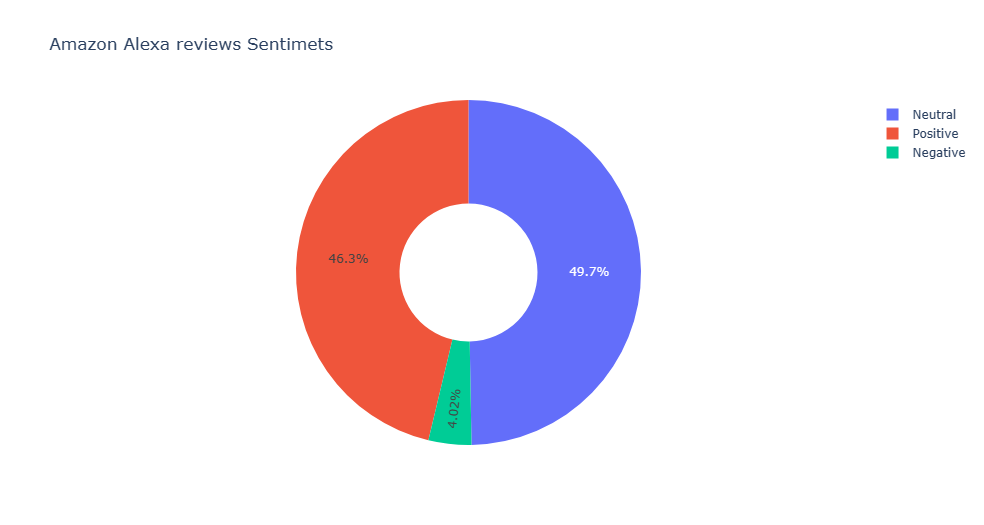

### Conclusion:
1. **Around 50% reviews are neutral, 46% are Positive & 4% reviews are negative.**
2. **Using SVM & Gradient Boosting we predicted sentiment class of real world Reviews.**